## Imports

In [84]:
from pydriller import Repository,Commit
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import pandas as pd
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from bert_score import score as bert_score
from g4f.Provider import Chatai
from sklearn.metrics.pairwise import cosine_similarity as cossim
import pickle
smooth = SmoothingFunction().method1
import asyncio
import os
from functools import partial
from transformers import logging
logging.set_verbosity_error()
from sentence_transformers import SentenceTransformer

from collections import defaultdict
import warnings
warnings.filterwarnings("ignore")
from g4f.client import AsyncClient

## BugMiner Class

In [2]:
class BugMiner:
    def __init__(self, repository, max_concurrency=8) -> None:
        self.repo_str = repository
        self.repo = Repository(repository)
        self.all_commits: list[Commit] = []
        self.load_commits()
        self.keywords = list(
            map(
                re.compile,
                [
                    "fixed ", " bug", "fixes ", "fix ", " fix", " fixed", " fixes", "crash", "solves", " resolves",
                    "resolves ", " issue", "issue ", "regression", "fall back", "assertion", "coverity", "reproducible",
                    "stack-wanted", "steps-wanted", "testcase", "failur", "fail", "npe ", " npe", "except", "broken",
                    "differential testing", "error", "hang ", " hang", "test fix", "steps to reproduce", "crash",
                    "assertion", "failure", "leak", "stack trace", "heap overflow", "freez", "problem ", " problem",
                    " overflow", "overflow ", "avoid ", " avoid", "workaround ", " workaround", "break ", " break",
                    " stop", "stop "
                ],
            )
        )
        self.pattern = re.compile(
            r".*((solv(ed|es|e|ing))|(fix(s|es|ing|ed)?)|((error|bug|issue)(s)?)).*"
        )
        self.embedding_model = SentenceTransformer('all-MiniLM-L12-v2')
        self.tokenizer = AutoTokenizer.from_pretrained("./CommitPredictorT5")
        self.model = AutoModelForSeq2SeqLM.from_pretrained("./CommitPredictorT5")
        self.ai_model = AsyncClient()
        self.semaphore = asyncio.Semaphore(max_concurrency)
        self.rectifier_prompt = """You are an assistant that produces a rectified commit message for a single modified file.
Input:
FILE: {}
ORIGINAL_COMMIT_MSG: "{}"
PARSED_DIFF:
{}

Produce a short rectified commit message [12-16 words] for this file maybe consisting of:
- Title
- One-line root cause
- One-line change summary

DO NOT OUTPUT ANYTHING ELSE and 8 TO 10 WORDS ONLY, starting filler messages etc.
"""

    def load_commits(self):
        if len(self.all_commits) == 0:
            for commit in self.repo.traverse_commits():
                self.all_commits.append(commit)

    def gen_wordcloud(self):
        text = " ".join([i.msg for i in self.all_commits])
        self.word_cloud = WordCloud(
            width=1600, height=800, background_color="white"
        ).generate(text)
        return self.word_cloud

    def bugfix_commits(self, count=-1):
        prev_cur_map: list[list[Commit, Commit]] = []
        i = 1
        while i < len(self.all_commits):
            current = self.all_commits[i]
            prev = self.all_commits[i - 1]
            commit_message = current.msg.lower()
            for kw in self.keywords:
                if (
                    kw.search(commit_message)
                    or self.pattern.search(commit_message)
                    or kw.pattern in commit_message
                ):
                    prev_cur_map.append([prev, current])
                    break
            i += 1
        if count > -1:
            prev_cur_map = np.array(prev_cur_map)
            rows = np.random.choice(len(prev_cur_map), size=count, replace=False)
            prev_cur_map = prev_cur_map[rows]
        self.prev_cur_map = prev_cur_map
        return prev_cur_map

    def save_bugfix_commits(self):
        rows = []
        for prev, cur in self.prev_cur_map:
            rows.append(
                {
                    "hash": cur.hash,
                    "message": cur.msg,
                    "hashes_of_parents": ",".join(cur.parents),
                    "is_merge_comit": cur.merge,
                    "modified_files": ",".join([i.filename for i in cur.modified_files]),
                }
            )
        df = pd.DataFrame(rows)
        df.to_csv(f"{self.repo_str}_bugfix_commits.csv")
        return

    def get_diff_msg_for_commit(self, commit_idx: int):
        cur_commit = self.prev_cur_map[commit_idx][1]
        modified_files = cur_commit.modified_files
        msgs = []
        for mf in modified_files:
            msg = f"--- {mf.old_path}\n" + f"+++ {mf.new_path}\n" + mf.diff
            msgs.append(msg)
        return msgs

    def parse_diff_for_file(self, diff_op):
        acc, before = [], None
        for line in diff_op.splitlines():
            if line.startswith("---"):
                before = line.split(maxsplit=1)[-1][1:] if " " in line else None
            elif line.startswith("+++"):
                after = line.split(maxsplit=1)[-1][1:] if " " in line else None
                if before == after:
                    acc.append(f"<ide><path>{before}")
                else:
                    acc += [f"<add><path>{after}", f"<del><path>{before}"]
                continue

            line = re.sub(r"@@[^@@]*@@", "", line)
            if not line:
                continue
            tag = (
                "<add>"
                if line.startswith("+")
                else "<del>" if line.startswith("-") else "<ide>"
            )
            acc.append(tag + (line[1:] if tag != "<ide>" else line))

        return "\n".join(acc)

    def predict_bug_type(
        self, diff_op, max_length=42, min_length=6, num_beams=7, prediction_count=1
    ):
        input_text = self.parse_diff_for_file(diff_op)
        with torch.no_grad():
            input_ids = self.tokenizer(
                input_text,
                truncation=True,
                padding=True,
                return_tensors="pt",
            ).input_ids

            outputs = self.model.generate(
                input_ids,
                max_length=max_length,
                min_length=min_length,
                num_beams=num_beams,
                num_return_sequences=prediction_count,
            )
        return self.tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]

    async def generate_embeddings(self, text):
        embeddings = await asyncio.to_thread(self.embedding_model.encode, [text])
        return embeddings[0].tolist()

    def cosine_similarity(self, emb1, emb2):
        return cossim(emb1.reshape(1, -1), emb2.reshape(1, -1))[0][0]

    async def get_rectified_message(self, file_path, diff, original_msg):
        response = await self.ai_model.chat.completions.create(
            model="phi-4",
            provider =Chatai,
            messages=[
                {
                    "role": "user",
                    "content": self.rectifier_prompt.format(file_path, original_msg, diff)
                }
            ],
            web_search = False
        )
        
        return response.choices[0].message.content


    async def compute_message_similarities(
        self, original_msg, predicted_msg, rectified_msg
    ):

        Pp, Rp, Fp = bert_score(
            [predicted_msg], [rectified_msg], lang="en", rescale_with_baseline=True
        )
        Pr, Rr, Fr = bert_score(
            [original_msg], [rectified_msg], lang="en", rescale_with_baseline=True
        )
        bert_f1_pred = float(Fp[0])
        bert_f1_orig = float(Fr[0])

        t = await self.generate_embeddings(original_msg)
        emb_orig = np.array(t)
        t = await self.generate_embeddings(predicted_msg)
        emb_pred = np.array(t)
        t = await self.generate_embeddings(rectified_msg)
        emb_rect = np.array(t)
        cos_orig = float(self.cosine_similarity(emb_orig, emb_rect))
        cos_pred = float(self.cosine_similarity(emb_pred, emb_rect))
        
        return {
            "bert_f1_pred": bert_f1_pred,
            "bert_f1_orig": bert_f1_orig,
            "cosine_pred": cos_pred,
            "cosine_orig": cos_orig,
        }, (emb_orig, emb_rect)

    async def _predict_in_executor(self, parsed, *args, **kwargs):
        loop = asyncio.get_running_loop()
        return await loop.run_in_executor(
            None, partial(self.predict_bug_type, parsed, *args, **kwargs)
        )

    async def _safe_rectify(self, path, parsed, orig_msg):
        async with self.semaphore:
            return await self.get_rectified_message(path, parsed, orig_msg)
    
    async def analyze_all_pairs(
        self,
        max_pairs=None,
        verbose=True,
        max_workers=8,
        save_dir="checkpoints",
        save_every=100,
        resume=True,
        state_filename="progress.pkl",
    ):
        os.makedirs(save_dir, exist_ok=True)
        state_path = os.path.join(save_dir, state_filename)

        
        def _serialize_state(processed_set, rows, commit_rect_sums, commit_orig_emb, file_count_per_commit, processed):
            
            rect_serial = {h: arr.tolist() for h, arr in commit_rect_sums.items()}
            orig_serial = {h: arr.tolist() for h, arr in commit_orig_emb.items()}
            state = {
                "processed_set": processed_set,
                "rows": rows,
                "commit_rect_sums": rect_serial,
                "commit_orig_emb": orig_serial,
                "file_count_per_commit": dict(file_count_per_commit),
                "processed": processed,
            }
            tmp = state_path + ".tmp"
            with open(tmp, "wb") as f:
                pickle.dump(state, f)
            os.replace(tmp, state_path)

        def _load_state():
            if not os.path.exists(state_path):
                return None
            with open(state_path, "rb") as f:
                state = pickle.load(f)
           
            commit_rect_sums_loaded = {h: np.array(arr) for h, arr in state["commit_rect_sums"].items()}
            commit_orig_emb_loaded = {h: np.array(arr) for h, arr in state["commit_orig_emb"].items()}
            return (
                set(tuple(x) for x in state["processed_set"]), 
                state["rows"],
                commit_rect_sums_loaded,
                commit_orig_emb_loaded,
                defaultdict(int, state["file_count_per_commit"]),
                state["processed"],
            )

       
        pairs = self.prev_cur_map if max_pairs is None else self.prev_cur_map[:max_pairs]

        
        full_index_list = []
        for pair_idx, (prev, cur) in enumerate(pairs):
            for mf_idx, mf in enumerate(cur.modified_files):
                full_index_list.append((pair_idx, mf_idx))
        
        if resume:
            loaded = _load_state()
        else:
            loaded = None

        if loaded:
            processed_set, rows, commit_rect_sums, commit_orig_emb, file_count_per_commit, processed = loaded
            if verbose:
                print(f"Resuming from saved state: {processed} files processed, {len(processed_set)} entries.")
        else:
            processed_set = set()              
            rows = []                          
            commit_rect_sums = {}              
            commit_orig_emb = {}               
            file_count_per_commit = defaultdict(int)
            processed = 0

        sem = asyncio.Semaphore(max_workers)

        async def handle_file(pair_idx: int, mf_idx: int):
            prev, cur = pairs[pair_idx]
            mf = cur.modified_files[mf_idx]
            orig_msg = cur.msg or ""
            path = getattr(mf, "new_path", None) or getattr(mf, "old_path", None)
            diff = f"--- {mf.old_path}\n+++ {mf.new_path}\n{mf.diff}"
            parsed = self.parse_diff_for_file(diff)

            predict_coro = self._predict_in_executor(parsed)
            rectify_coro = self._safe_rectify(path, parsed, orig_msg)

            predicted, rectified = await asyncio.gather(predict_coro, rectify_coro)

            sims, (emb_orig, emb_rect) = await self.compute_message_similarities(
                orig_msg, predicted, rectified
            )

            row = {
                "hash": cur.hash,
                "message": orig_msg,
                "source_code_before": mf.source_code_before,
                "source_code_current": mf.source_code,
                "diff": diff,
                "llm_inference": predicted,
                "rectified_msg": rectified,
                "timestamp": cur.committer_date.timestamp(),
                **sims,
            }
            return row, emb_orig, emb_rect, cur.hash

        async def sem_task(pair_idx: int, mf_idx: int):
            async with sem:
                return await handle_file(pair_idx, mf_idx)

        tasks = []
        for pair_idx, mf_idx in full_index_list:
            if (pair_idx, mf_idx) in processed_set:
                continue
            tasks.append(((pair_idx, mf_idx), asyncio.create_task(sem_task(pair_idx, mf_idx))))

        total_files = len(full_index_list)
        if verbose:
            print(f"Total modified-files (ordered): {total_files}. To process: {total_files - len(processed_set)}")

        pending = {t[1] for t in tasks}
        task_to_idx = {t[1]: t[0] for t in tasks}

        try:
            while pending:
                done, pending = await asyncio.wait(pending, return_when=asyncio.FIRST_COMPLETED)
                for fut in done:
                    pair_idx, mf_idx = task_to_idx[fut]
                    try:
                        row, emb_orig, emb_rect, h = await asyncio.shield(fut)
                    except Exception as exc:
                        
                        try:
                            _serialize_state(processed_set, rows, commit_rect_sums, commit_orig_emb, file_count_per_commit, processed)
                            
                            try:
                                tmp_pairs = os.path.join(save_dir, f"pairs_{processed}.csv.tmp")
                                out_pairs = os.path.join(save_dir, f"pairs_{processed}.csv")
                                pd.DataFrame(rows).to_csv(tmp_pairs, index=False)
                                os.replace(tmp_pairs, out_pairs)
                            except Exception:
                                pass
                        except Exception as e2:
                            print(f"Failed to write state on exception: {e2}")
                        raise exc

                    
                    rows.append(row)
                    processed_set.add((pair_idx, mf_idx))

                    
                    if h in commit_rect_sums:
                        commit_rect_sums[h] = commit_rect_sums[h] + emb_rect
                    else:
                        commit_rect_sums[h] = emb_rect.copy()
                    file_count_per_commit[h] += 1
                    if h not in commit_orig_emb:
                        commit_orig_emb[h] = emb_orig

                    processed += 1
                    if verbose and (processed % 10 == 0):
                        print(f"Processed {processed}/{total_files} files")

                    if processed % save_every == 0:
                        try:
                            
                            _serialize_state(processed_set, rows, commit_rect_sums, commit_orig_emb, file_count_per_commit, processed)

                           
                            df_pairs = pd.DataFrame(rows)
                            tmp_pairs = os.path.join(save_dir, f"pairs_{processed}.csv.tmp")
                            out_pairs = os.path.join(save_dir, f"pairs_{processed}.csv")
                            df_pairs.to_csv(tmp_pairs, index=False)
                            os.replace(tmp_pairs, out_pairs)

                            
                            commit_rows_partial = []
                            for h_k, rect_sum in commit_rect_sums.items():
                                n_files = file_count_per_commit[h_k]
                                mean_rect = rect_sum # / n_files
                                orig = commit_orig_emb.get(h_k)
                                diff_vec = orig - rect_sum
                                diff_l2 = float(np.linalg.norm(diff_vec))
                                diff_l1 = float(np.sum(np.abs(diff_vec)))
                                denom = (np.linalg.norm(orig) * np.linalg.norm(mean_rect))
                                cos_similarity = float((np.dot(orig, mean_rect) / denom)) if denom > 0 else np.nan
                                comm = next(Repository(self.repo_str, only_commits=[h_k]).traverse_commits(), None)
                                timestamp = comm.committer_date.timestamp() if comm is not None else None
                                commit_rows_partial.append(
                                    {
                                        "hash": h_k,
                                        "num_files": n_files,
                                        "mean_rect_norm": float(np.linalg.norm(mean_rect)),
                                        "diff_l2": diff_l2,
                                        "diff_l1": diff_l1,
                                        "cosine": cos_similarity,
                                        "timestamp": timestamp,
                                    }
                                )

                            df_comm_partial = pd.DataFrame(commit_rows_partial)
                            tmp_comm = os.path.join(save_dir, f"commits_{processed}.csv.tmp")
                            out_comm = os.path.join(save_dir, f"commits_{processed}.csv")
                            df_comm_partial.to_csv(tmp_comm, index=False)
                            os.replace(tmp_comm, out_comm)

                            if verbose:
                                print(f"Checkpoint saved at {processed} files -> {out_pairs}, {out_comm}")
                        except Exception as e:
                            print(f"Failed to write checkpoint at {processed}: {e}")

        except Exception:
            try:
                _serialize_state(processed_set, rows, commit_rect_sums, commit_orig_emb, file_count_per_commit, processed)
            except Exception:
                pass
            raise

        commit_rows = []
        for h, rect_sum in commit_rect_sums.items():
            n_files = file_count_per_commit[h]
            
            orig = commit_orig_emb.get(h)

            diff_vec = orig - rect_sum
            diff_l2 = float(np.linalg.norm(diff_vec))
            diff_l1 = float(np.sum(np.abs(diff_vec)))
            denom = (np.linalg.norm(orig) * np.linalg.norm(rect_sum))
            cos_similarity = float((np.dot(orig, rect_sum) / denom)) if denom > 0 else np.nan
            comm = next(Repository(self.repo_str, only_commits=[h]).traverse_commits(), None)
            commit_rows.append(
                {
                    "hash": h,
                    "num_files": file_count_per_commit[h],
                    "mean_rect_norm": float(np.linalg.norm(rect_sum)),
                    "diff_l2": diff_l2,
                    "diff_l1": diff_l1,
                    "cosine": cos_similarity,
                    "timestamp": comm.committer_date.timestamp() if comm is not None else None,
                }
            )

        try:
            _serialize_state(processed_set, rows, commit_rect_sums, commit_orig_emb, file_count_per_commit, processed)
            tmp_pairs = os.path.join(save_dir, f"pairs_{processed}.csv.tmp")
            out_pairs = os.path.join(save_dir, f"pairs_{processed}.csv")
            pd.DataFrame(rows).to_csv(tmp_pairs, index=False)
            os.replace(tmp_pairs, out_pairs)
            tmp_comm = os.path.join(save_dir, f"commits_{processed}.csv.tmp")
            out_comm = os.path.join(save_dir, f"commits_{processed}.csv")
            pd.DataFrame(commit_rows).to_csv(tmp_comm, index=False)
            os.replace(tmp_comm, out_comm)
        except Exception:
            pass

        return pd.DataFrame(rows), pd.DataFrame(commit_rows)

    def plot_similarity_timeseries(self, results_df, metric="cosine_pred"):
        
        agg = results_df.groupby("pair_idx")[
            metric
        ].mean()  
        plt.figure(figsize=(10, 4))
        plt.plot(agg.values, marker=".")
        plt.xlabel("Bug-fix pairs (chronological)")
        plt.ylabel(metric)
        plt.title(f"{metric} across bug-fix pairs")
        plt.ylim(0, 1)
        plt.tight_layout()
        plt.show()

## Running BugMiner on discord.py repository

In [3]:
miner = BugMiner('discord.py',max_concurrency=16)

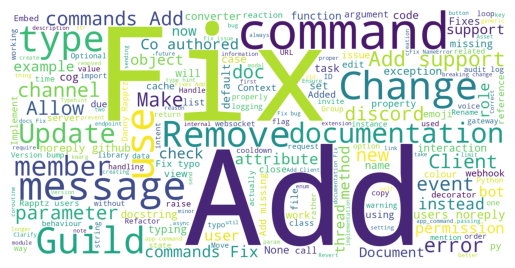

In [15]:
plt.imshow(miner.gen_wordcloud())
plt.axis('off')
plt.show()

In [4]:
miner.bugfix_commits()
print()

In [85]:
len(miner.all_commits)

5243

In [86]:
len(miner.prev_cur_map)

1875

In [5]:
miner.save_bugfix_commits()

In [9]:
df = pd.read_csv('discord.py_bugfix_commits.csv')
df.sample(n=6)

,Unnamed: 0,hash,message,hashes_of_parents,is_merge_comit,modified_files
596,596,d9e54d7dd36368bb97b3c31225901ba80cb81a62,[commands] Redesign extension exception flow.\...,26e9b5bfac840c95744bbdd0ab356842e9efa72f,False,"bot.py,errors.py,api.rst"
1192,1192,e795d341e7315483fd30053ba96f69a8c72d4343,Change View dispatch mechanism to be keyed by ...,f72350199d5ed09e0e56e7a270249bf51ab78af1,False,view.py
1782,1782,078b500657c651f72a6ca78ada23332422e23adf,Fix dynamic item views having a timeout causin...,9ce733321b445db245924bfd21fedf20a01a570b,False,view.py
972,972,ed2650f7864229464b3317c08abde4345959f191,Fix documented type of `Command.usage`,bbbda4ec0072ae225b8feaba3c2ad65ac6f5490c,False,core.py
984,984,88c23125ffd462e62084f2e1a1dd0f446bf127fc,Allow CustomActivity emoji to be constructed a...,0cd1a88316a9d35d54da04b6992cb26e7b0e7527,False,activity.py
1145,1145,0fae0b49952558b67286caafc43abca7149b66f1,"Use ""raised"" instead of ""thrown"" for exception...",7ca90874b94d30c396268c17b9583018ed3f80bd,False,errors.py


In [ ]:

ddf,df2 = await miner.analyze_all_pairs(verbose=True,max_workers=16,save_every=100)

Resuming from saved state: 2204 files processed, 2204 entries.
Total modified-files (ordered): 3774. To process: 1570
Processed 2210/3774 files
Processed 2220/3774 files
Processed 2230/3774 files
Processed 2240/3774 files
Processed 2250/3774 files
Processed 2260/3774 files
Processed 2270/3774 files
Processed 2280/3774 files
Processed 2290/3774 files
Processed 2300/3774 files
Checkpoint saved at 2300 files -> checkpoints\pairs_2300.csv, checkpoints\commits_2300.csv
Processed 2310/3774 files
Processed 2320/3774 files
Processed 2330/3774 files
Processed 2340/3774 files
Processed 2350/3774 files
Processed 2360/3774 files
Processed 2370/3774 files
Processed 2380/3774 files
Processed 2390/3774 files
Processed 2400/3774 files
Checkpoint saved at 2400 files -> checkpoints\pairs_2400.csv, checkpoints\commits_2400.csv


TimeoutError: 

Task exception was never retrieved
future: <Task finished name='Task-113334' coro=<BugMiner.analyze_all_pairs.<locals>.sem_task() done, defined at C:\Users\GSRAJA\AppData\Local\Temp\ipykernel_18780\1505333928.py:520> exception=TimeoutError()>
Traceback (most recent call last):
  File "c:\Users\GSRAJA\Desktop\IIT GN\sem5\sttcse\Labs\STT_Lab_2\venv\Lib\site-packages\aiohttp\client_reqrep.py", line 532, in start
    message, payload = await protocol.read()  # type: ignore[union-attr]
                       ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\GSRAJA\Desktop\IIT GN\sem5\sttcse\Labs\STT_Lab_2\venv\Lib\site-packages\aiohttp\streams.py", line 672, in read
    await self._waiter
asyncio.exceptions.CancelledError

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "C:\Users\GSRAJA\AppData\Local\Temp\ipykernel_18780\1505333928.py", line 522, in sem_task
    return await handle_file(pair_idx, mf_idx)
           ^^^^^^^^^^^^^^^^^^^^^^^

## Plots and Thresholds

In [10]:
pairs = pd.read_csv('checkpoints\pairs_2405.csv')
commits = pd.read_csv('checkpoints\commits_2400.csv')

In [87]:
len(pairs),len(commits)

(2405, 1397)

In [11]:
llm_inference_cos = pairs.sort_values('timestamp')['cosine_pred'].values
dev_inference_cos = pairs.sort_values('timestamp')['cosine_orig'].values
rectifier_cos = commits.sort_values('timestamp')['cosine'].values

### LLM and Developer Comparison

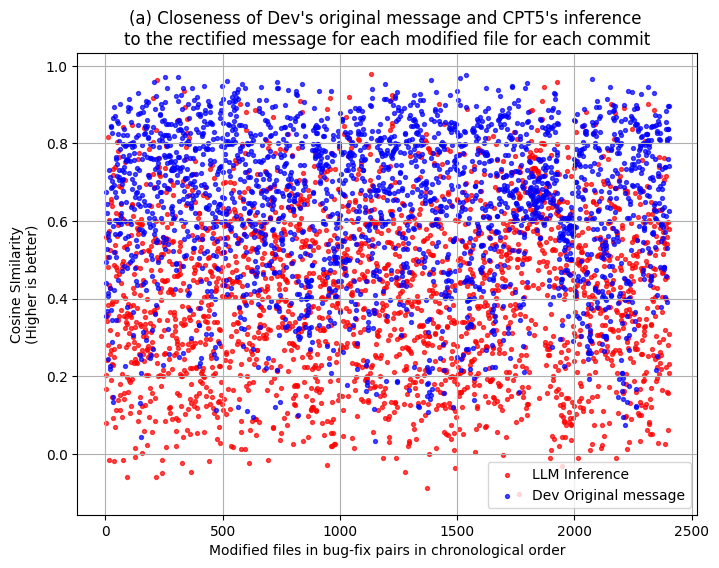

In [67]:
plt.figure(figsize=(8,6))
plt.scatter(np.arange(1,len(llm_inference_cos)+1,1), llm_inference_cos,alpha=0.7,s=8,c='r',label='LLM Inference')
plt.scatter(np.arange(1,len(dev_inference_cos)+1,1), dev_inference_cos,alpha=0.7,s=8,c='b',label='Dev Original message')
plt.xlabel('Modified files in bug-fix pairs in chronological order')
plt.ylabel('Cosine SImilarity\n(Higher is better)')
plt.legend()
plt.grid()
plt.title('(a) Closeness of Dev\'s original message and CPT5\'s inference \nto the rectified message for each modified file for each commit')
plt.show()

### LLM Hit rate

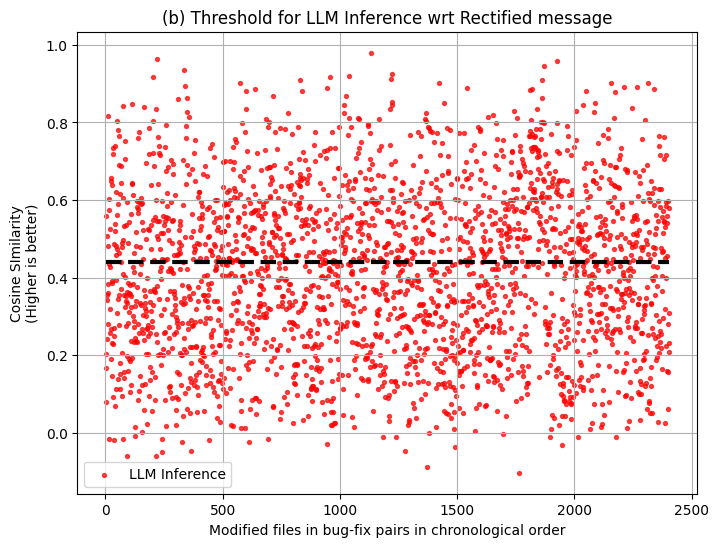

In [66]:
plt.figure(figsize=(8,6))
plt.scatter(np.arange(1,len(llm_inference_cos)+1,1), llm_inference_cos,alpha=0.7,s=8,c='r',label='LLM Inference')
threshold = np.mean(dev_inference_cos[llm_inference_cos > dev_inference_cos])
plt.plot([1, len(llm_inference_cos)],[threshold,threshold],'k--',lw='3')
plt.xlabel('Modified files in bug-fix pairs in chronological order')
plt.ylabel('Cosine SImilarity\n(Higher is better)')
plt.legend()
plt.grid()
plt.title('(b) Threshold for LLM Inference wrt Rectified message')
plt.show()

In [57]:
threshold

np.float64(0.4388815375088439)

In [56]:
llm_hitrate = sum(llm_inference_cos > threshold)*100/len(llm_inference_cos)
llm_hitrate

np.float64(46.61122661122661)

### Developer Hit rate

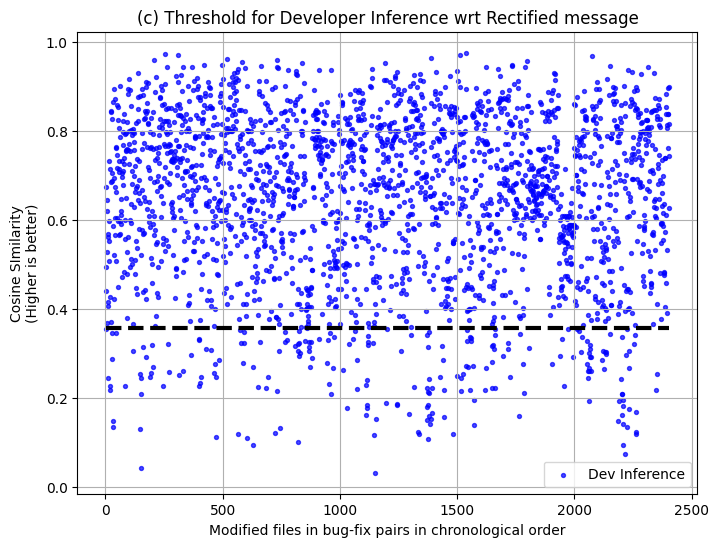

In [65]:
plt.figure(figsize=(8,6))
plt.scatter(np.arange(1,len(dev_inference_cos)+1,1), dev_inference_cos,alpha=0.7,s=8,c='b',label='Dev Inference')
threshold = np.mean(llm_inference_cos[dev_inference_cos > llm_inference_cos])
plt.plot([1, len(dev_inference_cos)],[threshold,threshold],'k--',lw='3')
plt.xlabel('Modified files in bug-fix pairs in chronological order')
plt.ylabel('Cosine SImilarity\n(Higher is better)')
plt.legend()
plt.grid()
plt.title('(c) Threshold for Developer Inference wrt Rectified message')
plt.show()

In [59]:
threshold

np.float64(0.35741361551892764)

In [61]:
llm_hitrate = sum(dev_inference_cos > threshold)*100/len(dev_inference_cos)
llm_hitrate

np.float64(90.68607068607069)

### Rectifier Hit rate

In [70]:
media_absolute_deviation = np.median(np.abs(rectifier_cos - np.median(rectifier_cos)))

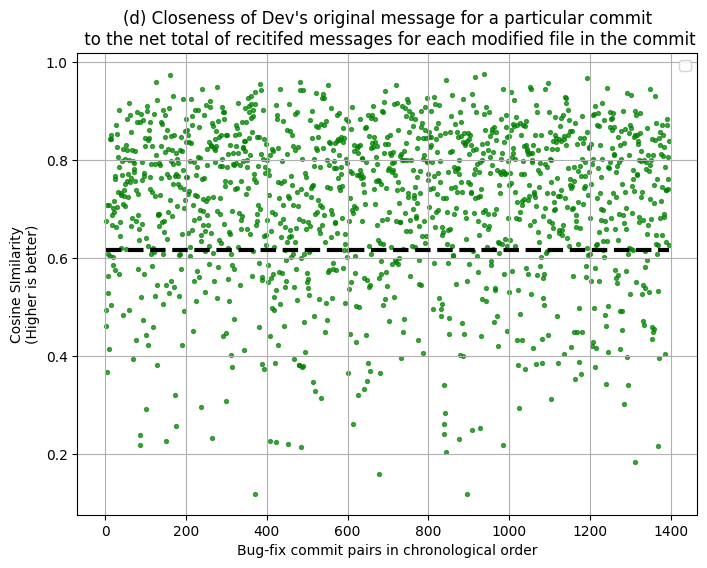

In [78]:
plt.figure(figsize=(8,6))
plt.scatter(np.arange(1,len(rectifier_cos)+1,1), rectifier_cos,alpha=0.7,s=8,c='g')
threshold = np.median(rectifier_cos) - 1.3 * media_absolute_deviation
plt.plot([1, len(rectifier_cos)],[threshold,threshold],'k--',lw='3')
plt.xlabel('Bug-fix commit pairs in chronological order')
plt.ylabel('Cosine SImilarity\n(Higher is better)')
plt.legend()
plt.grid()
plt.title('(d) Closeness of Dev\'s original message for a particular commit\n to the net total of recitifed messages for each modified file in the commit')
plt.show()

In [80]:
threshold

np.float64(0.6156430557661251)

In [ ]:
sum(rectifier_cos < threshold)*100/len(rectifier_cos)

np.float64(23.407301360057264)